The dataset used for the project is the [Real or Not? dataset](https://www.kaggle.com/c/nlp-getting-started/data) from Kaggle which contains text-based Tweets about natural disasters.

The goal of this project is to predict which tweets are about real disasters and which ones are not.

The Real Tweets are actually about disasters, for example:

```
Jetstar and Virgin forced to cancel Bali flights again because of ash from Mount Raung volcano
The Not Real Tweets are Tweets not about disasters (they can be on anything), for example:

'Education is the most powerful weapon which you can use to change the world.' Nelson #Mandela #quote
```

### Import and Visualize the Data

In [1]:
# Turn the csv files into a pandas dataframe
import pandas as pd
train = pd.read_csv("/content/drive/MyDrive/natural_language_processing_with_disaster_tweets/train.csv")
test = pd.read_csv("/content/drive/MyDrive/natural_language_processing_with_disaster_tweets/test.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [2]:
# Shuffle the training dataframe
train_shuffled = train.sample(frac=1, random_state=42)
train_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [3]:
# Check the first 5 rows of the test dataframe
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
# Check the example of each class we have
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

- 1 = A real disaster tweet
- 0 = Not a real disaster tweet

In [5]:
# Check the total number of samples in the train and test set
print(f"Total training samples: {len(train)}")
print(f"Total test samples: {len(test)}")
print(f"Total samples: {len(train) + len(test)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [6]:
# Visualize some random training examples
import random
random_index = random.randint(0, len(train)-5)
for row in train_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
WACKOS like #MicheleBachman predict the WORLD will SOON be OBLITERATED by a burning firey INFERNO but cant accept #GlobalWarming!! HELLO!!!

---

Target: 1 (real disaster)
Text:
RaÌ¼l sends a message of condolence to Vietnam following natural disaster: On behalf of the Cuban government an... http://t.co/EmrZiCb004

---

Target: 0 (not real disaster)
Text:
@Lwilliams_13 I'll drown you in the river walk

---

Target: 0 (not real disaster)
Text:
@DetroitPls interested to see who will win this battle

---

Target: 1 (real disaster)
Text:
sevenfigz has a crush: http://t.co/20B3PnQxMD

---



### Split the data into train and validation set

In [7]:
from sklearn.model_selection import train_test_split

# use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_shuffled["text"].to_numpy(),
                                                                            train_shuffled["target"].to_numpy(),
                                                                            test_size = 0.2, # 20% of samples for validation set
                                                                            random_state = 42) # random state

In [8]:
# Check the length of the splitted data
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6090, 1523, 6090, 1523)

In [9]:
# View the first 5 train sentences and their labels
train_sentences[:5], train_labels[:5]

(array(['Detonation fashionable mountaineering electronic watch water-resistant couples leisure tab\x89Û_ http://t.co/E61x9Y65QD http://t.co/OVLET0gDqm',
        "Men escape car engulfed in flames in Parley's Canyon crews investigating cause - http://t.co/tFan6qq2Ys http://t.co/rAkwWritPo",
        'I-77 Mile Marker 31 to 40 South Mooresville  Iredell Vehicle Accident Congestion at 8/6 1:18 PM',
        "#Greece's tax revenues collapse as debt crisis continues via @guardian #bailout http://t.co/cJvbQXw83s ^mp",
        'Be not afraid of sudden fear neither of the desolation of the wicked when it cometh. For the Lord shall be thy... http://t.co/bP597YDs2b'],
       dtype=object),
 array([0, 1, 1, 1, 0]))

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=None)

For max_tokens (the number of words in the vocabulary), multiples of 10,000 (10,000, 20,000, 30,000) or the exact number of unique words in your text (e.g. 32,179) are common values.


In [11]:
# Find average number of tokens (words) in training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [12]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequence will be. i.e how many words from a tweet does our model see?

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = "int",
                                    output_sequence_length = max_length)

In [13]:
# fit the vectorizer to the training data
text_vectorizer.adapt(train_sentences)

In [14]:
# Create sample sentence and tokenize it. Test the text_vectorizer on a custom sentence
sample_sentence = "There is food at home!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 75,   9, 242,  17, 154,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [15]:
# choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Learn How I Gained Access To The Secrets Of The Top Earners &amp; Used Them To Explode My Home Business Here: http://t.co/8rABhQrTh5 Please #RT      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 849,   62,    8, 2736, 2041,    5,    2, 1482,    6,    2,  194,
        2792,   35,  431,   85]])>

In [16]:
# get the unique tokens(words) in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # first 5 most common tokens
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 words in vocab: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 words in vocab: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['minded', 'mindblowing', 'milne', 'milledgeville', 'millcityio']


### Creating an Embedding using an Embedding Layer

In [17]:
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length, # set input shape
                             output_dim = 128, # set size of embedding vector
                             embeddings_initializer = "uniform", # default, initialize randomly
                             input_length = max_length, # how long is each input
                             name = "embedding_1")

In [18]:
# Get a random sentence from training set to test the embedding layer
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
Former heroin addict shares story as city leaders sound alarm: City officials said emergency teams responded t... http://t.co/GZxIPMOknB      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01193111, -0.01049782, -0.00380228, ...,  0.04079118,
         -0.01174756, -0.04825428],
        [ 0.01203727,  0.02013853,  0.0277444 , ..., -0.01927481,
         -0.01151016,  0.03192401],
        [-0.03064449,  0.04151857,  0.03369817, ...,  0.02616682,
          0.04429445,  0.00290688],
        ...,
        [-0.00451725,  0.04257568, -0.01578333, ..., -0.0385166 ,
          0.01525331,  0.0452388 ],
        [ 0.00279449,  0.00035509, -0.02829071, ..., -0.00241803,
         -0.02987779,  0.04491181],
        [-0.03066472,  0.0335811 ,  0.04325818, ..., -0.02570668,
          0.03866345,  0.03320971]]], dtype=float32)>

Each token in the sentence gets turned into a length 128 feature vector.

### Modelling a text dataset

I'm going to build a series of different models, each as its own experiment. I'll then compare the results of each model and see which one performed best.

More specifically, I'll be building the following:

- Model 0: Naive Bayes (baseline)
- Model 1: Feed-forward neural network (dense model)
- Model 2: LSTM model
- Model 3: GRU model
- Model 4: Bidirectional-LSTM model
- Model 5: 1D Convolutional Neural Network
- Model 6: TensorFlow Hub Pretrained Feature Extractor
- Model 7: Same as model 6 with 10% of training data

Model 0 is the simplest to acquire a baseline which the other models will be expected to beat.

### Model 0: Naive Bayes Baseline Model

To create the baseline, I'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert the words to numbers and then model them with the Multinomial Naive Bayes algorithm

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([("tfidf", TfidfVectorizer()), # convert words into numbers using tfidf
                    ("clf", MultinomialNB()) # Model the text
                    ])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [20]:
# Evaluate the NB model and find the baseline metric
baseline_score = model_0.score(val_sentences, val_labels)
print(f"The baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

The baseline model achieves an accuracy of: 79.91%


In [21]:
# Make predictions with the NB baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0])

### Create an Evaluation Function

In [22]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  calculates model accuracy, precision, recall and f1 scoere of a binary classification model.
  Args:
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array
  Returns a dictionary of accuracy, precision, recall and f1 score.
  """

  # Calculate the models accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [23]:
# get baseline results
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.9080761654629,
 'precision': 0.8146358812834972,
 'recall': 0.799080761654629,
 'f1': 0.7920155324845473}

### Model 1: Feed-Forward Neural Network(A simple dense model)

In [24]:
# Create tensorboard callback (need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [25]:
# Build the feed forward NN with a functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1D strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding
outputs =layers.Dense(1, activation="sigmoid")(x)
model_1 =tf.keras.Model(inputs, outputs, name = "model_1_dense")

# Compile the model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model and pass the tensorboard callback function to make sure the model's training metrics are logged
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20240108-064110
Epoch 1/5
191/191 [==============================] - 19s 83ms/step - loss: 0.6192 - accuracy: 0.6860 - val_loss: 0.5482 - val_accuracy: 0.7485
Epoch 2/5
191/191 [==============================] - 7s 36ms/step - loss: 0.4538 - accuracy: 0.8141 - val_loss: 0.4760 - val_accuracy: 0.7840
Epoch 3/5
191/191 [==============================] - 2s 8ms/step - loss: 0.3532 - accuracy: 0.8606 - val_loss: 0.4636 - val_accuracy: 0.7945
Epoch 4/5
191/191 [==============================] - 2s 9ms/step - loss: 0.2865 - accuracy: 0.8905 - val_loss: 0.4646 - val_accuracy: 0.7892
Epoch 5/5
191/191 [==============================] - 1s 7ms/step - loss: 0.2374 - accuracy: 0.9122 - val_loss: 0.4759 - val_accuracy: 0.7932


In [26]:
# get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [27]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

48/48 [==============================] - 0s 3ms/step - loss: 0.4759 - accuracy: 0.7932


[0.47590816020965576, 0.7931713461875916]

In [28]:
# make predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

48/48 [==============================] - 0s 2ms/step


array([[0.42345303],
       [0.87685704],
       [0.99698263],
       [0.1384104 ],
       [0.1050238 ],
       [0.944197  ],
       [0.96936184],
       [0.9925982 ],
       [0.9363174 ],
       [0.28976297]], dtype=float32)

In [29]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [30]:
# Compare the models predictions to the ground truth
model_1_results = calculate_results(y_true = val_labels,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 79.31713722915299,
 'precision': 0.7946875401114287,
 'recall': 0.7931713722915299,
 'f1': 0.7905686999197213}

In [31]:
# Compare the Feed forward NN model to the baseline naivebayes model
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

Since I'll be doing this kind of comparison (naive bayes baseline compared to new model) quite a few times, i'll create a function to automate the process.

In [32]:
# Create a helper function to compare the baseline results to the new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 79.91, New accuracy: 79.32, Difference: -0.59
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.80, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.79, Difference: -0.00


## Recurrent Neural Network
### Model 2: LSTM

In [33]:
# Set random seed and create a new embedding layer for the LSTM model
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x) # return vector for the whole sequence
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="LSTM")])

(None, 15, 128)
(None, 64)
Saving TensorBoard log files to: model_logs/LSTM/20240108-064143
Epoch 1/5
191/191 [==============================] - 11s 45ms/step - loss: 0.5160 - accuracy: 0.7409 - val_loss: 0.4553 - val_accuracy: 0.7846
Epoch 2/5
191/191 [==============================] - 3s 14ms/step - loss: 0.3079 - accuracy: 0.8745 - val_loss: 0.4940 - val_accuracy: 0.7873
Epoch 3/5
191/191 [==============================] - 2s 11ms/step - loss: 0.2071 - accuracy: 0.9241 - val_loss: 0.5692 - val_accuracy: 0.7787
Epoch 4/5
191/191 [==============================] - 2s 11ms/step - loss: 0.1428 - accuracy: 0.9527 - val_loss: 0.7243 - val_accuracy: 0.7544
Epoch 5/5
191/191 [==============================] - 2s 11ms/step - loss: 0.1068 - accuracy: 0.9614 - val_loss: 0.7831 - val_accuracy: 0.7754


In [34]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [35]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

48/48 [==============================] - 1s 3ms/step


((1523, 1),
 array([[0.03142675],
        [0.96915466],
        [0.999199  ],
        [0.02557107],
        [0.0039985 ],
        [0.9990513 ],
        [0.80904585],
        [0.9997502 ],
        [0.99883276],
        [0.09420814]], dtype=float32))

In [36]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10], val_labels[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>,
 array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [37]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.54432042022324,
 'precision': 0.777514467396053,
 'recall': 0.7754432042022325,
 'f1': 0.7719114963994704}

In [38]:
# Compare model 2 result to baseline result
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.91, New accuracy: 77.54, Difference: -2.36
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.80, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 3: Gated Recurrent Unit(GRU)

In [39]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim =max_vocab_length,
                                     output_dim= 128,
                                     embeddings_initializer = "uniform",
                                     input_length = max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GU")

# Compile the GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="GRU")])

Saving TensorBoard log files to: model_logs/GRU/20240108-064207
Epoch 1/5
191/191 [==============================] - 9s 37ms/step - loss: 0.5388 - accuracy: 0.7181 - val_loss: 0.4560 - val_accuracy: 0.7892
Epoch 2/5
191/191 [==============================] - 4s 20ms/step - loss: 0.3155 - accuracy: 0.8683 - val_loss: 0.4784 - val_accuracy: 0.7925
Epoch 3/5
191/191 [==============================] - 2s 10ms/step - loss: 0.2088 - accuracy: 0.9217 - val_loss: 0.5600 - val_accuracy: 0.7807
Epoch 4/5
191/191 [==============================] - 2s 11ms/step - loss: 0.1437 - accuracy: 0.9488 - val_loss: 0.6772 - val_accuracy: 0.7518
Epoch 5/5
191/191 [==============================] - 2s 8ms/step - loss: 0.1087 - accuracy: 0.9645 - val_loss: 0.6843 - val_accuracy: 0.7840


In [40]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [41]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

48/48 [==============================] - 0s 3ms/step


((1523, 1),
 array([[0.15586366],
        [0.9942741 ],
        [0.99951386],
        [0.02899387],
        [0.0038134 ],
        [0.9980756 ],
        [0.71831024],
        [0.9994911 ],
        [0.99568814],
        [0.08655411]], dtype=float32))

In [42]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [43]:
# Calculate model_3_results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 78.39789888378202,
 'precision': 0.7872369354510318,
 'recall': 0.7839789888378201,
 'f1': 0.7801963124427604}

In [44]:
# Compare the GRU results to the naive bayes baseline results
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.91, New accuracy: 78.40, Difference: -1.51
Baseline precision: 0.81, New precision: 0.79, Difference: -0.03
Baseline recall: 0.80, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


### Model 4: Bidirectonal RNN model

In [45]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a bidirectional RNN in Tensorflow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

# Compile the Bidirectional RNN Model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20240108-064227
Epoch 1/5
191/191 [==============================] - 13s 45ms/step - loss: 0.5118 - accuracy: 0.7433 - val_loss: 0.4610 - val_accuracy: 0.7833
Epoch 2/5
191/191 [==============================] - 3s 16ms/step - loss: 0.2990 - accuracy: 0.8790 - val_loss: 0.4999 - val_accuracy: 0.7833
Epoch 3/5
191/191 [==============================] - 2s 12ms/step - loss: 0.1925 - accuracy: 0.9314 - val_loss: 0.5959 - val_accuracy: 0.7748
Epoch 4/5
191/191 [==============================] - 4s 19ms/step - loss: 0.1307 - accuracy: 0.9567 - val_loss: 0.6475 - val_accuracy: 0.7525
Epoch 5/5
191/191 [==============================] - 2s 11ms/step - loss: 0.0923 - accuracy: 0.9681 - val_loss: 0.7692 - val_accuracy: 0.7695


In [46]:
# Summary of the Bidirectional Model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [47]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

48/48 [==============================] - 1s 3ms/step


array([[0.03638116],
       [0.8785193 ],
       [0.99855584],
       [0.04636757],
       [0.00280019],
       [0.99588937],
       [0.9074592 ],
       [0.99976426],
       [0.99850106],
       [0.11420929]], dtype=float32)

In [48]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [49]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.95338148391333,
 'precision': 0.7701224342063411,
 'recall': 0.7695338148391333,
 'f1': 0.7667145368657939}

In [50]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.91, New accuracy: 76.95, Difference: -2.95
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.80, New recall: 0.77, Difference: -0.03
Baseline f1: 0.79, New f1: 0.77, Difference: -0.03


### Model 5: Conv1D

In [51]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the Conv1D layer
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20240108-064312
Epoch 1/5
191/191 [==============================] - 11s 40ms/step - loss: 0.5798 - accuracy: 0.7069 - val_loss: 0.4763 - val_accuracy: 0.7846
Epoch 2/5
191/191 [==============================] - 2s 12ms/step - loss: 0.3494 - accuracy: 0.8555 - val_loss: 0.4720 - val_accuracy: 0.7958
Epoch 3/5
191/191 [==============================] - 2s 9ms/step - loss: 0.2041 - accuracy: 0.9269 - val_loss: 0.5408 - val_accuracy: 0.7814
Epoch 4/5
191/191 [==============================] - 3s 16ms/step - loss: 0.1244 - accuracy: 0.9601 - val_loss: 0.6201 - val_accuracy: 0.7564
Epoch 5/5
191/191 [==============================] - 3s 14ms/step - loss: 0.0873 - accuracy: 0.9719 - val_loss: 0.6806 - val_accuracy: 0.7761


In [52]:
# Summary of the 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)              

In [53]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

48/48 [==============================] - 0s 2ms/step


array([[0.76069844],
       [0.9902534 ],
       [0.9989384 ],
       [0.04860691],
       [0.00243002],
       [0.99754363],
       [0.96391886],
       [0.998406  ],
       [0.9995925 ],
       [0.14076641]], dtype=float32)

In [54]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [55]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 77.60998030203545,
 'precision': 0.7756211936629285,
 'recall': 0.7760998030203545,
 'f1': 0.7744977295547814}

In [56]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.91, New accuracy: 77.61, Difference: -2.30
Baseline precision: 0.81, New precision: 0.78, Difference: -0.04
Baseline recall: 0.80, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [57]:
# Use this encoding layer in place of the text_vectorizer and embedding layer
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow1/variations/universal-sentence-encoder/versions/2",
                                        input_shape=[], # shape of inputs coming to the model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights
                                        name="USE")

In [58]:
# Create the model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer, # takes in sentences and then encodes them into an embedding
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20240108-064402
Epoch 1/5
191/191 [==============================] - 6s 12ms/step - loss: 0.4861 - accuracy: 0.7989 - val_loss: 0.4457 - val_accuracy: 0.8083
Epoch 2/5
191/191 [==============================] - 2s 12ms/step - loss: 0.4181 - accuracy: 0.8215 - val_loss: 0.4421 - val_accuracy: 0.8030
Epoch 3/5
191/191 [==============================] - 2s 13ms/step - loss: 0.4078 - accuracy: 0.8233 - val_loss: 0.4423 - val_accuracy: 0.8056
Epoch 4/5
191/191 [==============================] - 3s 17ms/step - loss: 0.4007 - accuracy: 0.8258 - val_loss: 0.4377 - val_accuracy: 0.8024
Epoch 5/5
191/191 [==============================] - 2s 12ms/step - loss: 0.3949 - accuracy: 0.8276 - val_loss: 0.4395 - val_accuracy: 0.8050


In [59]:
# Summary of the pretrained universal sentence encoder
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 32897 (128.50 KB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
# Make predictions with the USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

48/48 [==============================] - 0s 7ms/step


array([[0.29472598],
       [0.8324212 ],
       [0.9897093 ],
       [0.18376999],
       [0.8508689 ],
       [0.8668693 ],
       [0.9691676 ],
       [0.9332309 ],
       [0.9526476 ],
       [0.09126746]], dtype=float32)

In [61]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [62]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 80.49901510177281,
 'precision': 0.8057492105913169,
 'recall': 0.8049901510177282,
 'f1': 0.8031240687815979}

In [63]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.91, New accuracy: 80.50, Difference: 0.59
Baseline precision: 0.81, New precision: 0.81, Difference: -0.01
Baseline recall: 0.80, New recall: 0.80, Difference: 0.01
Baseline f1: 0.79, New f1: 0.80, Difference: 0.01


### Model 7: TensorFlow Hub Pretrained Sentence Encoder on 10% of the training data

In [64]:
# split the already split train_sentences/train_labels
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [65]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6090
Length of 10% training examples: 609


In [66]:
# Check the number of targets in the subset of data
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    326
1    283
dtype: int64

To make sure i'm making an appropriate comparison between the model's ability to learn from the full training set and 10% subset, i'll clone the USE model `(model_6)` using the `tf.keras.models.clone_model()` method.

Doing this will create the same architecture but reset the learned weights of the clone target (pretrained weights from the USE will remain but all others will be reset).

In [67]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model to the 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20240108-064433
Epoch 1/5
20/20 [==============================] - 2s 41ms/step - loss: 0.6556 - accuracy: 0.7094 - val_loss: 0.6175 - val_accuracy: 0.7630
Epoch 2/5
20/20 [==============================] - 1s 27ms/step - loss: 0.5751 - accuracy: 0.7915 - val_loss: 0.5451 - val_accuracy: 0.7761
Epoch 3/5
20/20 [==============================] - 1s 43ms/step - loss: 0.5050 - accuracy: 0.8062 - val_loss: 0.5002 - val_accuracy: 0.7774
Epoch 4/5
20/20 [==============================] - 1s 27ms/step - loss: 0.4617 - accuracy: 0.8128 - val_loss: 0.4776 - val_accuracy: 0.7787
Epoch 5/5
20/20 [==============================] - 1s 27ms/step - loss: 0.4373 - accuracy: 0.8161 - val_loss: 0.4689 - val_accuracy: 0.7833


In [68]:
# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 32897 (128.50 KB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [69]:
# Make predictions with the nodel trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

48/48 [==============================] - 0s 7ms/step


array([[0.16009964],
       [0.8269013 ],
       [0.9183018 ],
       [0.13719861],
       [0.7988881 ],
       [0.8548573 ],
       [0.90163285],
       [0.91156125],
       [0.82119936],
       [0.10853475]], dtype=float32)

In [70]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [71]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 78.3322390019698,
 'precision': 0.7826786094802914,
 'recall': 0.783322390019698,
 'f1': 0.782731907729503}

In [72]:
# Compare to the Naive Bayes baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.91, New accuracy: 78.33, Difference: -1.58
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.80, New recall: 0.78, Difference: -0.02
Baseline f1: 0.79, New f1: 0.78, Difference: -0.01


### Comparing the performance of each of our models

In [73]:
# Combine the model results into a Dateframe
all_model_results = pd.DataFrame({"naive bayes baseline": baseline_results,
                                  "simple_dense(Feed Forward NN)": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_precent_data": model_7_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
naive bayes baseline,79.908076,0.814636,0.799081,0.792016
simple_dense(Feed Forward NN),79.317137,0.794688,0.793171,0.790569
lstm,77.544320,0.777514,0.775443,0.771911
gru,78.397899,0.787237,0.783979,0.780196
bidirectional,76.953381,0.770122,0.769534,0.766715
conv1d,77.609980,0.775621,0.776100,0.774498
tf_hub_sentence_encoder,80.499015,0.805749,0.804990,0.803124
tf_hub_10_precent_data,78.332239,0.782679,0.783322,0.782732


In [74]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

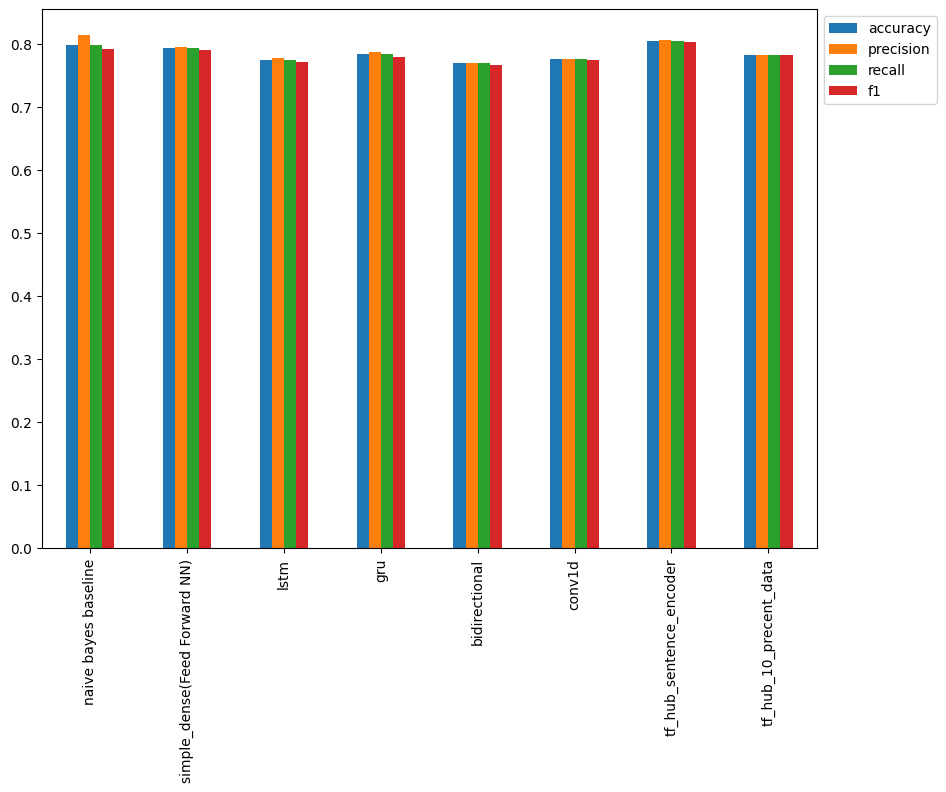

In [75]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

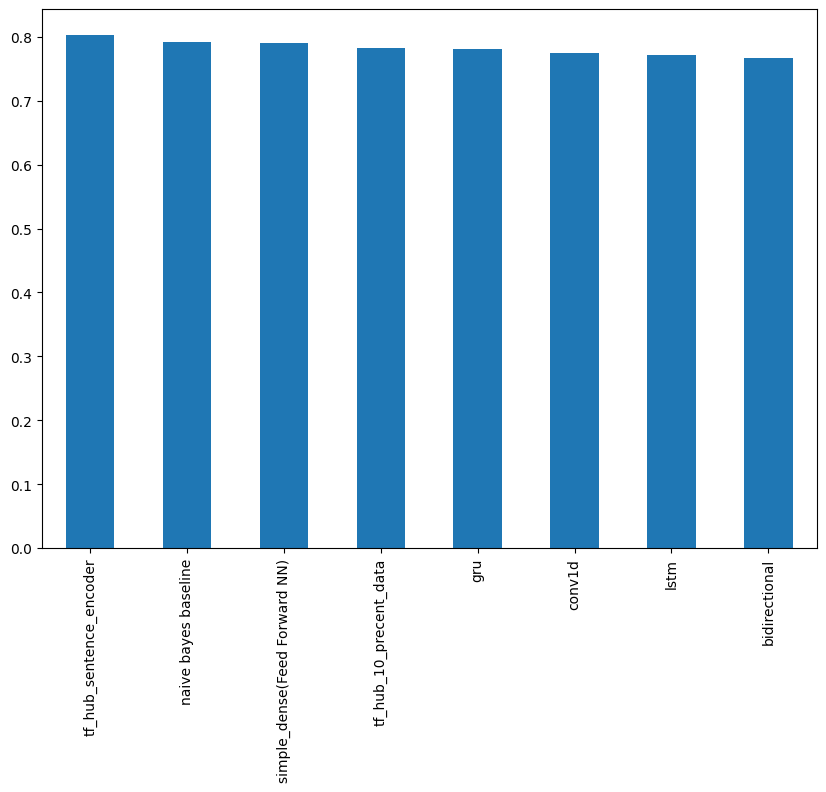

In [76]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

### Combining our models (model ensembling/stacking)

I'm going to combine the baseline `model (model_0`), `LSTM model (model_2)` and the USE model trained on the full training data `(model_6)` by averaging the combined prediction probabilities of each.

In [77]:
# Get mean prediction probabilities for the 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

Evaluate the combined predictions against the true labels and add the stacked model's results to the `all_model_results` DataFrame.

In [78]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 79.25147734734077,
 'precision': 0.7919071107821365,
 'recall': 0.7925147734734077,
 'f1': 0.791760277746958}

In [79]:
# Add the combined model's results to the results dataframe
all_model_results.loc["ensemble_results"] = ensemble_results

In [80]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

In [81]:
all_model_results

,accuracy,precision,recall,f1
naive bayes baseline,0.799081,0.814636,0.799081,0.792016
simple_dense(Feed Forward NN),0.793171,0.794688,0.793171,0.790569
lstm,0.775443,0.777514,0.775443,0.771911
gru,0.783979,0.787237,0.783979,0.780196
bidirectional,0.769534,0.770122,0.769534,0.766715
conv1d,0.776100,0.775621,0.776100,0.774498
tf_hub_sentence_encoder,0.804990,0.805749,0.804990,0.803124
tf_hub_10_precent_data,0.783322,0.782679,0.783322,0.782732
ensemble_results,0.792515,0.791907,0.792515,0.791760


### Saving and loading a trained model

In [82]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [83]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [84]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

48/48 [==============================] - 1s 7ms/step - loss: 0.4395 - accuracy: 0.8050


[0.4394766092300415, 0.8049901723861694]

### Finding the most wrong examples

If many of our modelling experiments are returning similar results, despite using different kinds of models, it's a good idea to return to the data and inspect why this might be.

One of the best ways to inspect your data is to sort your model's predictions and find the samples it got most wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

To make things visual, I'll take the best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

- If the best model still isn't perfect, what examples is it getting wrong?
- Which ones are the most wrong?
- Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this

In [85]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.294726
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.832421
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.989709
3,@camilacabello97 Internally and externally scr...,1,0.0,0.183770
4,Radiation emergency #preparedness starts with ...,1,1.0,0.850869


In [86]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
846,Mourning notices for stabbing arson victims st...,0,1.0,0.959524
881,@adorableappple No reported flooding po in the...,0,1.0,0.943703
813,Aug. 5: The Fort Calhoun Nuclear Station is at...,0,1.0,0.934344
80,GENERAL AUDIENCE: On Wounded Families | ZENIT ...,0,1.0,0.922975
1502,Two Jewish Terrorists Charged In Historic-Chur...,0,1.0,0.922606
181,Article by Michael Jackman at Metro Times Detr...,0,1.0,0.920673
1307,We should all have a fire safety plan. RT @Mat...,0,1.0,0.917039
549,Day 2. Liquidation of emergency at chemical ob...,0,1.0,0.911317
303,Trafford Centre film fans angry after Odeon ci...,0,1.0,0.900751
1468,U.S National Park Services Tonto National Fore...,0,1.0,0.899220


Write code to visualize the sample text, truth label, prediction class and prediction probability. Because i've sorted the samples by prediction probability, viewing samples from the head of the most_wrong DataFrame will display the false positives.

A reminder:

- 0 = Not a real disaster Tweet
- 1 = Real disaster Tweet

In [87]:
# Check the false positives (model predicted 1 when should have been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9595244526863098
Text:
Mourning notices for stabbing arson victims stir Û÷politics of griefÛª in Israel: Posters for Shira Banki and A... http://t.co/3GZ5zQQTHe

----

Target: 0, Pred: 1, Prob: 0.9437034130096436
Text:
@adorableappple No reported flooding po in the area. Ten-4. #mmda

----

Target: 0, Pred: 1, Prob: 0.934344470500946
Text:
Aug. 5: The Fort Calhoun Nuclear Station is at 100% capacity today according to the NRC: http://t.co/pztbQImpuW

----

Target: 0, Pred: 1, Prob: 0.9229751229286194
Text:
GENERAL AUDIENCE: On Wounded Families | ZENIT - The World Seen From Rome http://t.co/hFvnyfT78C

----

Target: 0, Pred: 1, Prob: 0.9226059317588806
Text:
Two Jewish Terrorists Charged In Historic-Church Arson | The Ugly Truth http://t.co/iEksNFSbY7 http://t.co/VWCf3slkrW

----

Target: 0, Pred: 1, Prob: 0.9206734895706177
Text:
Article by Michael Jackman at Metro Times Detroit:
The group later downgraded the estimate to 37 square miles of... http://t.co/

In [88]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.06966173648834229
Text:
Next May I'll be free...from school from obligations like family.... Best of all that damn curfew...

----

Target: 1, Pred: 0, Prob: 0.06389295309782028
Text:
I went to pick up my lunch today and the bartender was holding my change hostage because he wanted my number. ??

----

Target: 1, Pred: 0, Prob: 0.06297937780618668
Text:
'I did another one I did another one. You still ain't done shit about the other one.' Nigga body bagging Meek.

----

Target: 1, Pred: 0, Prob: 0.06281078606843948
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.05773095414042473
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.05147647485136986
Text:
destroy the free fandom honestly

----

Target: 1, Pred: 0, Prob: 0.05088776722550392
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.04943408444523811
Text:
Why are you deluged with lo

### Making predictions on the test dataset

In [118]:
# Making predictions on the test dataset

test_sentences = test["text"].tolist()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

1/1 [==============================] - 0s 134ms/step
Pred: 0, Prob: 0.2775961756706238
Text:
@YoungHeroesID 
4. LAVA BLAST dan POWER RED #PantherAttack @Mirnawan_13 @Zakia_kiia

----

1/1 [==============================] - 0s 70ms/step
Pred: 1, Prob: 0.9799829721450806
Text:
Pic of 16yr old PKK suicide bomber who detonated bomb in Turkey Army trench released: Harun Ìàekdar a member o... http://t.co/v0NTQyZlPK

----

1/1 [==============================] - 0s 59ms/step
Pred: 1, Prob: 0.5992830991744995
Text:
@bodminmoor1 experienced the expertise of some of Cornwalls finest emergency and rescue services!

----

1/1 [==============================] - 0s 55ms/step
Pred: 0, Prob: 0.21191728115081787
Text:
the Burning Legion has returned

----

1/1 [==============================] - 0s 79ms/step
Pred: 0, Prob: 0.06994509696960449
Text:
HE SAID THE DOMINOS LAVA CAKES WERE BETTER THAN CULINARY CUISINE

----

1/1 [==============================] - 0s 53ms/step
Pred: 1, Prob: 0.9801791906356812


In [122]:
# Predict on the test dataset
test_pred_probs = model_6.predict(test['text'].tolist())
test_pred_probs[:10]

102/102 [==============================] - 1s 11ms/step


array([[0.64643306],
       [0.9438208 ],
       [0.70788777],
       [0.92371553],
       [0.96362585],
       [0.58397424],
       [0.10375959],
       [0.0568493 ],
       [0.07541077],
       [0.08592643]], dtype=float32)

In [123]:
# Convert prediction probabilities to labels
test_preds = tf.squeeze(tf.round(test_pred_probs))
test_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [124]:
model_submission['target'] = tf.squeeze(tf.round(test_pred_probs))
model_submission.to_csv('model_submission.csv', index=False)
model_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.372357
std,3146.427221,0.483507
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [126]:
model_submission.head()

,id,target
0,0,1.0
1,2,1.0
2,3,1.0
3,9,1.0
4,11,1.0


### Predicting on Tweets from the wild

In [90]:
# Turn Tweet into string
my_tweet = "I give you the desert chameleon, whose ability to blend itself into the background tells you all you need to know about the roots of ecology and the foundations of a personal identity"

In [91]:
# Function to take a model and an example sentence and return a prediction
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on a sentence

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [92]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence = my_tweet)

1/1 [==============================] - 0s 38ms/step
Pred: 0.0 (not real disaster) Prob: 0.13935314118862152
Text:
I give you the desert chameleon, whose ability to blend itself into the background tells you all you need to know about the roots of ecology and the foundations of a personal identity


I'll use a few Tweets about actual diasters such as the following two Tweets about the 2020 Beirut explosions to test if the model will actually predict if the tweet is a disaster or not.

In [93]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [94]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

1/1 [==============================] - 0s 37ms/step
Pred: 1.0 (real disaster) Prob: 0.9408992528915405
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [95]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

1/1 [==============================] - 0s 34ms/step
Pred: 1.0 (real disaster) Prob: 0.984468400478363
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


### The speed/score tradeoff

One of the final tests i'm going to do is to find the speed/score tradeoffs between the USE best model and baseline model.

Why is this important?

Although it can be tempting to just choose the best performing model through experimentation, this model might not actually work in a production setting.

Imagine you're Twitter and receive 1 million Tweets per hour (this is a made up number, the actual number is much higher). And you're trying to build a disaster detection system to read Tweets and alert authorities with details about a disaster in close to real-time.

Compute power isn't free so you're limited to a single compute machine for the project. On that machine, one of the models makes 10,000 predictions per second at 80% accuracy where as another one of the models (a larger model) makes 100 predictions per second at 85% accuracy.

Which model do you choose?

Is the second model's performance boost worth missing out on the extra capacity?

Of course, there are many options one could try here, such as sending as many Tweets as possible to the first model and then sending the ones which the model is least certain of to the second model.

The point here is to illustrate the best model you find through experimentation, might not be the model you end up using in production.

To make this more concrete, we'll write a function to take a model and a number of samples and time how long the given model takes to make predictions on those samples.

In [96]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [97]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

48/48 [==============================] - 0s 7ms/step


(0.6796668210000121, 0.00044626843138543144)

In [98]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.02777520799998001, 1.8237168745883134e-05)

The best performing USE model takes over 10x the time to make predictions as the baseline Naive Bayes model.

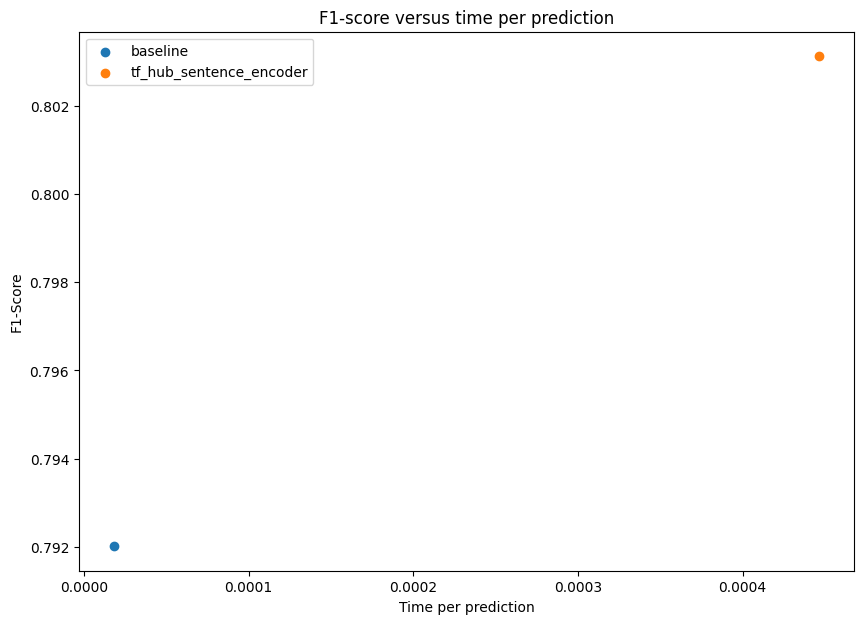

In [99]:
# compare time per prediction versus the model's F1-scores.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");